# Imports and helper functions

In [53]:
import os
# change directory in order to be able to import python scripts from the common package
if os.getcwd().endswith('crafter_rl'): os.chdir(os.path.expanduser(".."))

In [54]:
import torch
from common import psm
import matplotlib.pylab as plt
import numpy as np
from env import CrafterReplayBuffer, simplify_actions


In [55]:

def compare2_imgs(a,b,title1, title2, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*2, scale))
   axarr = [fig.add_subplot(121), fig.add_subplot(122)]
   axarr[0].imshow(a.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(b.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

def compare_imgs(a,b,c,title1, title2, title3, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*3, scale))
   axarr = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
   axarr[0].imshow(a.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(b.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(c.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   axarr[2].title.set_text(title3)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

# Manual calculation of PSE

First MPD:
| $x_n \sim \mathcal{X}$ | $x_1$  | $x_2$  | $x_3$|$x_4$|$x_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{X}^*(x)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{X}^*(x))$ |0|0|0|1|0|

Second MPD:
| $y_n \sim \mathcal{Y}$|$y_1$|$y_2$|$y_3$|$y_4$|$y_5$|
|-:|:-:|:-:|:-:|:-:|:-:|
| $\pi_\mathcal{Y}^*(y)$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}0\\1\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|$\begin{bmatrix}1\\0\end{bmatrix}$|
| $\arg \max(\pi_\mathcal{Y}^*(y))$ |0|1|0|0|0|

$
\begin{align}
d^*(x,y) &= TV(\pi_\mathcal{X}^*(\cdot |x), \pi_\mathcal{Y}^*(\cdot |y)) + \gamma W_1(d^*)\left( P_\mathcal{X}^{\pi^*}(\cdot|x),P_\mathcal{Y}^{\pi^*}(\cdot|y) \right) 
\\
d^*(x_i,y_j) &= TV(\arg \max(\pi_\mathcal{X}^*(x_i)),\arg \max(\pi_\mathcal{Y}^*(y_j))) + \gamma d^*(x_{i+1}, y_{j+1})
\\
d^*(x_i,y_j) &= TV(a_{\mathcal{X}, i}^*,a_{\mathcal{Y}, i}^*) + \gamma d^*(x_{i+1}, y_{j+1})
\\[.4cm]
\text{for two specific states (see table above):}
\\
d^*(x_2,y_2) &= TV(0,1) + \gamma \cdot d^*(x_3,y_3) \\
&= TV(0,1) + \gamma \cdot TV(0,0) + \gamma^2  \cdot TV(1,0) + \gamma^3 \cdot TV(0,0) \\
&= 1 + \gamma^2 = 1.9801
\end{align}
$

|$d(x_1, y_1)$|$d(x_1, y_2)$|$d(x_1, y_3)$|$d(x_1, y_4)$|$d(x_1, y_5)$|
|:-:|:-:|:-:|:-:|:-:|
|$d(x_2, y_1)$|$d(x_2, y_2)$|$d(x_2, y_3)$|$d(x_2, y_4)$|$d(x_2, y_5)$|
|$d(x_3, y_1)$|$d(x_3, y_2)$|$d(x_3, y_3)$|$d(x_3, y_4)$|$d(x_3, y_5)$|
|$d(x_4, y_1)$|$d(x_4, y_2)$|$d(x_4, y_3)$|$d(x_4, y_4)$|$d(x_4, y_5)$|
|$d(x_5, y_1)$|$d(x_5, y_2)$|$d(x_5, y_3)$|$d(x_5, y_4)$|$d(x_5, y_5)$|

$d(x_5, y_5) = TV(a_{x5}, a_{y5}) = TV(0,0) = 0$ <br>
$d(x_4, y_4) = TV(a_{x4}, a_{y4}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) = 1$ <br>
$d(x_3, y_3) = TV(a_{x3}, a_{y3}) + \gamma \cdot TV(a_{x4}, a_{y4}) = TV(0,0) + \gamma \cdot 1 = 0.99$ <br>
$d(x_2, y_2) = TV(a_{x2}, a_{y2}) + \gamma \cdot TV(a_{x3}, a_{y3}) = TV(0,1) + \gamma \cdot 0.99 = 1.9801$ <br>
$d(x_1, y_1) = TV(a_{x1}, a_{y1}) + \gamma \cdot TV(a_{x2}, a_{y2}) = TV(0,0) + \gamma \cdot 1.9801 = 1.960299$ <br>

Is the following really correct? If there is no state $y_{i+1}$ then we just take $y_{i}$? Where is this indicated in the formulars? 

$d(x_4, y_5) = TV(a_{x4}, a_{y5}) + \gamma \cdot TV(a_{x5}, a_{y5}) = TV(1,0) + \gamma \cdot 0 = 1$<br>
$d(x_3, y_5) = TV(a_{x3}, a_{y5}) + \gamma \cdot TV(a_{x4}, a_{y5}) = TV(0,0) + \gamma \cdot 1 = 0.99$<br>
$d(x_2, y_5) = TV(a_{x2}, a_{y5}) + \gamma \cdot TV(a_{x3}, a_{y5}) = TV(0,0) + \gamma \cdot 0.99 = 0.9801$<br>
$d(x_1, y_5) = TV(a_{x1}, a_{y5}) + \gamma \cdot TV(a_{x2}, a_{y5}) = TV(0,0) + \gamma \cdot 0.9801 = 0.970299$<br>

Without recursion: <br>
$\begin{align}
d(x_1, y_3) &= \gamma^0 TV(a_{x1}, a_{y3}) + \gamma^1 TV(a_{x2}, a_{y4}) + \gamma^2 TV(a_{x3}, a_{y5}) + \gamma^3 TV(a_{x4}, a_{y5}) + \gamma^4 TV(a_{x5}, a_{y5})\\
&= \gamma^0 TV(0,0) + \gamma^1 TV(0,0) + \gamma^2 TV(0,0) + \gamma^3 TV(1,0) + \gamma^4 TV(0,0)\\
&=  \gamma^3 = 0.970299
\end{align}$


# PSE on dummy transitions

In [56]:
# calculate PSM for specific states x and y
def psm_single(x_arr, y_arr, x_idx, y_idx, gamma=0.99):
    """
    Calculates the psm for the enire sequence (starting at the first element)
    """
    tv = 0. if x_arr[x_idx] == y_arr[y_idx] else 1.
    if(x_idx == len(x_arr)-1 and y_idx == len(y_arr)-1):
        return tv
    else:
        return tv + gamma * psm_single(x_arr,y_arr, min(x_idx+1, len(x_arr)-1), min(y_idx+1, len(y_arr)-1), gamma)


for i in range(0,5):
    for j in range(0,5):
        print(f"{psm_single([0,0,0,20,0], [0,1,0,0,0], x_idx = i, y_idx=j):.6f}", end=', ')
    print("")

1.960299, 1.970299, 0.970299, 0.970299, 0.970299, 
1.970100, 1.980100, 0.980100, 0.980100, 0.980100, 
0.990000, 1.990000, 0.990000, 0.990000, 0.990000, 
1.990000, 1.000000, 1.000000, 1.000000, 1.000000, 
0.990000, 1.000000, 0.000000, 0.000000, 0.000000, 


In [57]:
Mx = torch.tensor([0,0,0,1,0])#.to('cuda:0')
My = torch.tensor([0,20,0,0,0])#.to('cuda:0')

In [58]:
# calculate it like in the paper
print(psm.psm_f_fast(Mx, My))

tensor([[1.9960, 1.9970, 0.9970, 0.9970, 0.9970],
        [1.9970, 1.9980, 0.9980, 0.9980, 0.9980],
        [0.9990, 1.9990, 0.9990, 0.9990, 0.9990],
        [1.9990, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9990, 1.0000, 0.0000, 0.0000, 0.0000]])


In [59]:
# calculate psm for all states from X and Y 
print(psm.psm_default(Mx, My))

tensor([[1.9960, 1.9970, 0.9970, 0.9970, 0.9970],
        [1.9970, 1.9980, 0.9980, 0.9980, 0.9980],
        [0.9990, 1.9990, 0.9990, 0.9990, 0.9990],
        [1.9990, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.9990, 1.0000, 0.0000, 0.0000, 0.0000]])


In [60]:
# calcualte psm forward and backward
print(psm.psm_fb(Mx, My))

tensor([[1.9603, 2.9703, 1.9603, 1.9504, 1.9406],
        [1.9701, 2.9801, 1.9701, 1.9602, 1.9504],
        [0.9900, 2.9900, 1.9800, 1.9701, 1.9603],
        [2.9900, 2.0000, 2.9900, 2.9801, 2.9703],
        [1.9800, 2.9900, 0.9900, 1.9701, 1.9603]])


In [61]:
# calcualte psm forward and backward fast
print(psm.psm_fb_fast(Mx, My))

tensor([[1.9960, 2.9970, 1.9960, 1.9950, 1.9940],
        [1.9970, 2.9980, 1.9970, 1.9960, 1.9950],
        [0.9990, 2.9990, 1.9980, 1.9970, 1.9960],
        [2.9990, 2.0000, 2.9990, 2.9980, 2.9970],
        [1.9980, 2.9990, 0.9990, 1.9970, 1.9960]])


In [62]:
buffer = CrafterReplayBuffer("cpu", 8, './crafter_rl/dataset')
states_x, actions_x = buffer.sample_trajectory()
states_y, actions_y = buffer.sample_trajectory()
print(f"State shapes: x: {states_x.shape}, y: {states_y.shape}")

State shapes: x: torch.Size([327, 3, 64, 64]), y: torch.Size([523, 3, 64, 64])


In [63]:
# states_x, actions_x = states_x[-200:], actions_x[-200:] 
# states_y, actions_y = states_y[-200:], actions_y[-200:] 

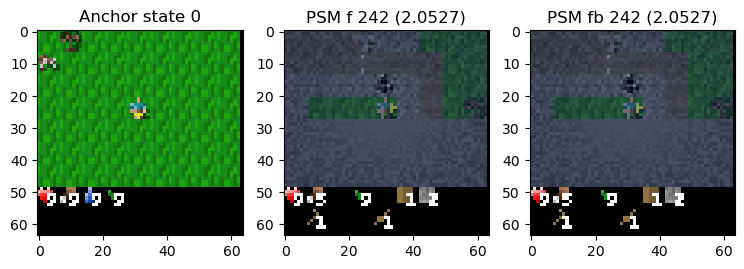

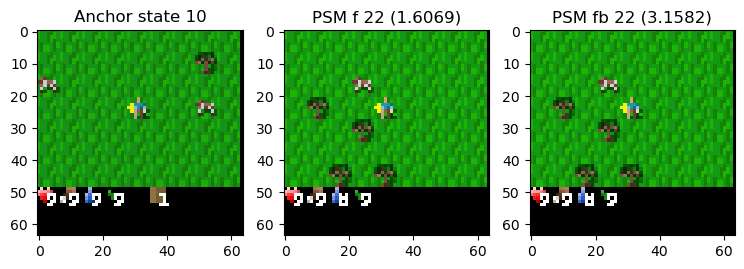

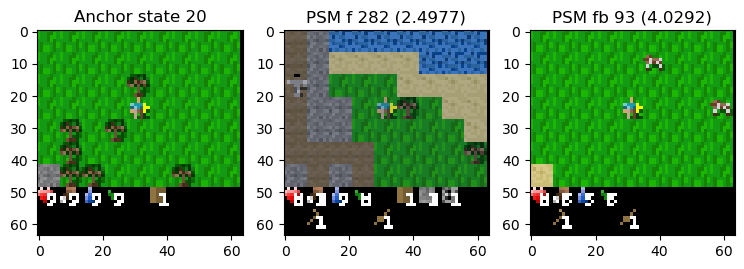

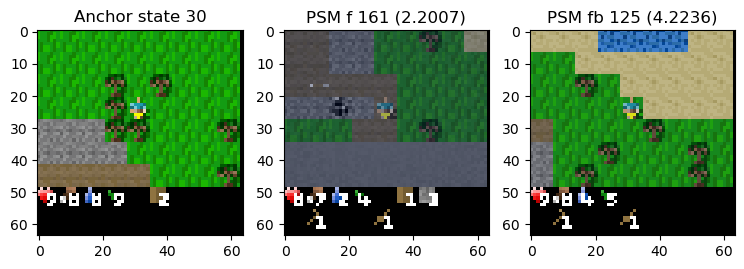

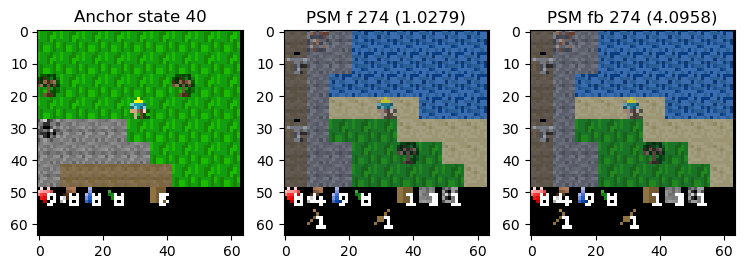

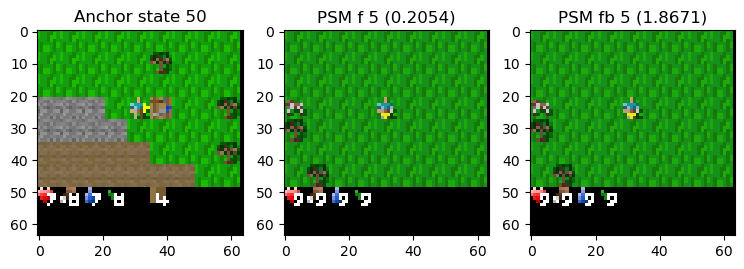

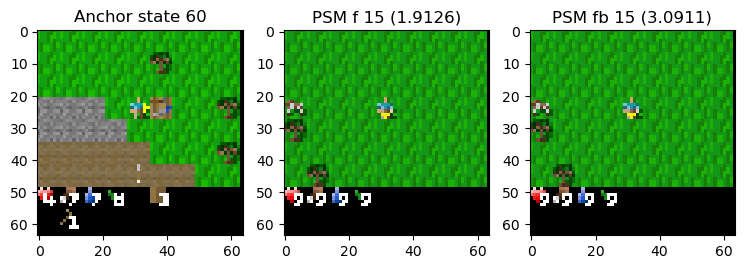

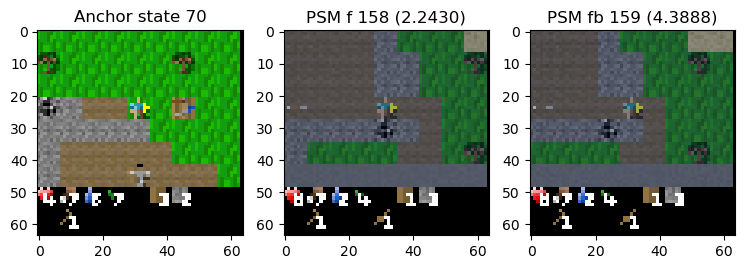

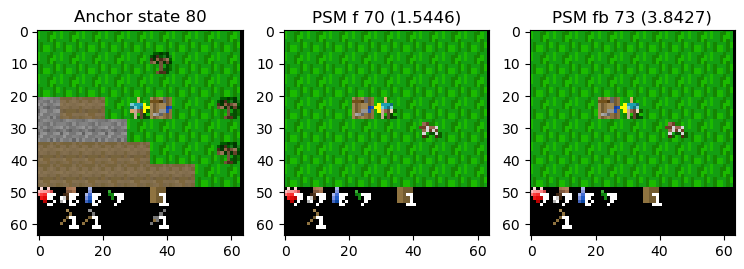

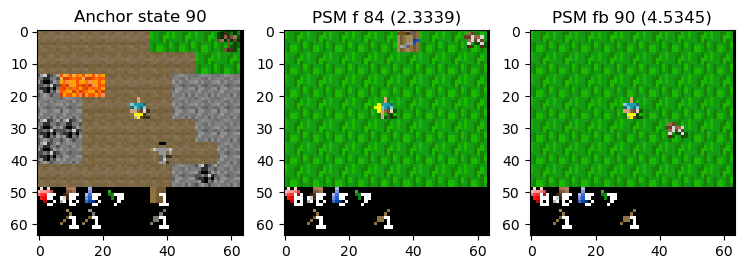

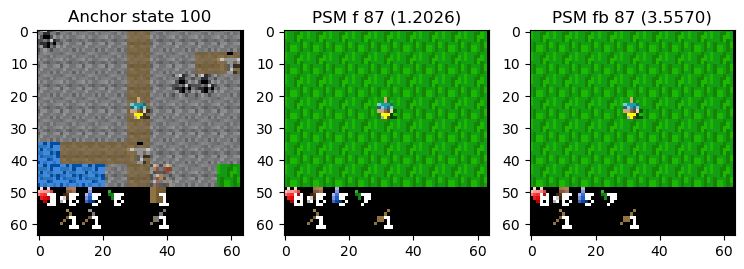

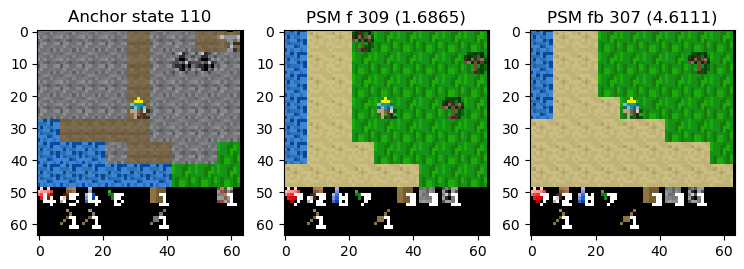

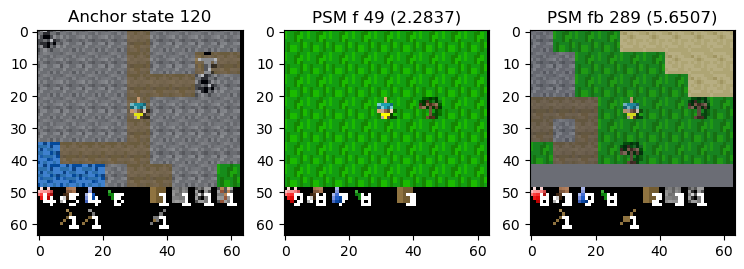

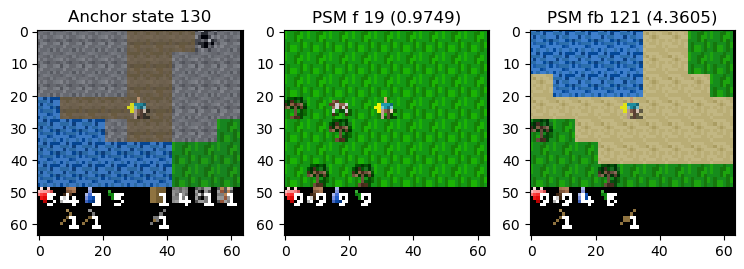

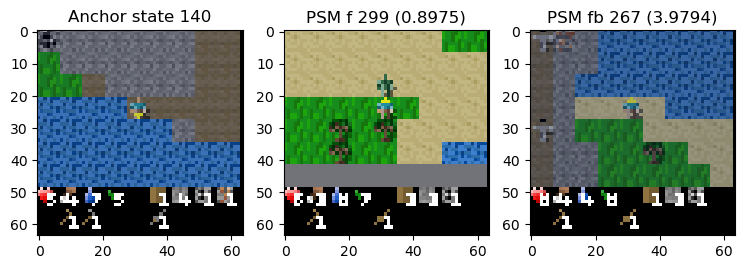

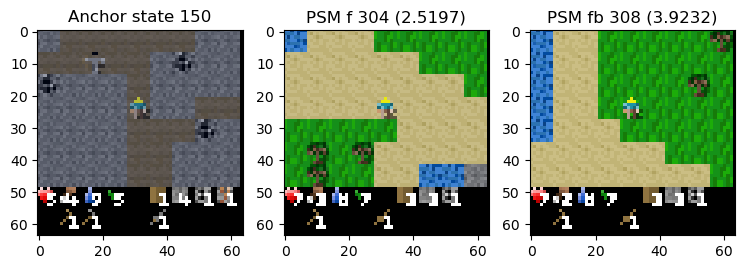

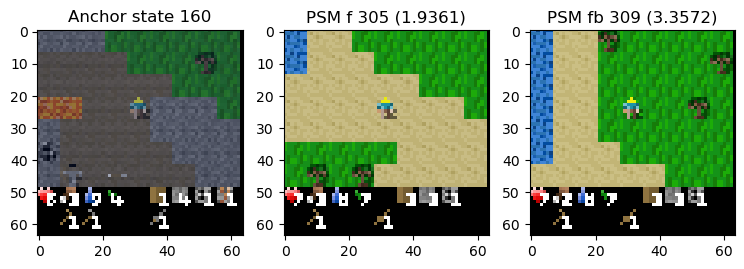

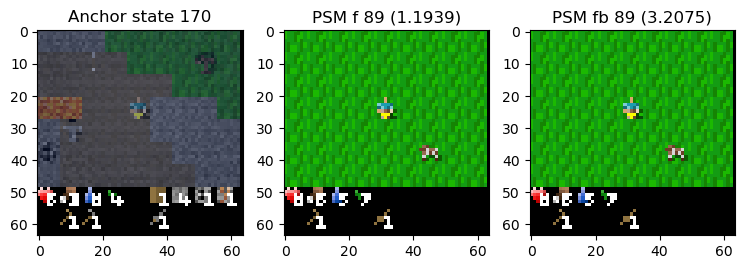

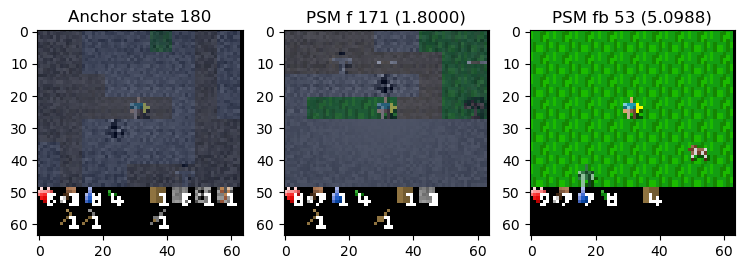

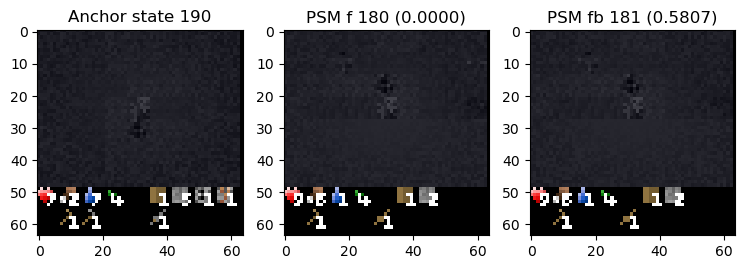

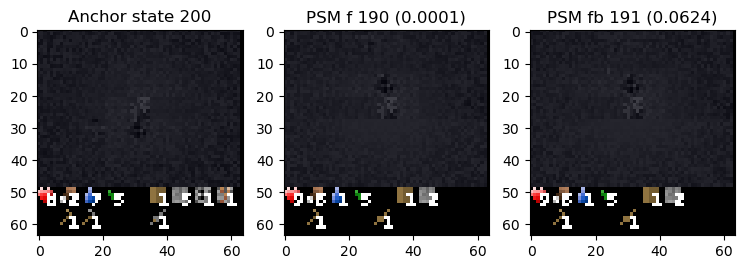

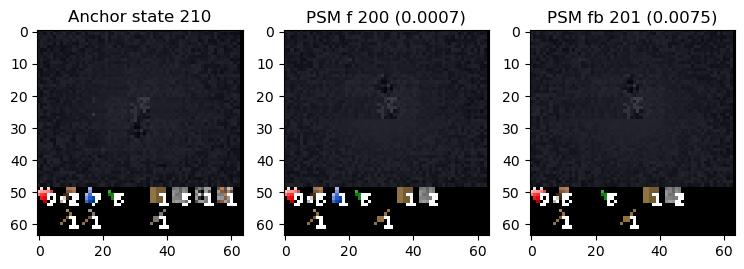

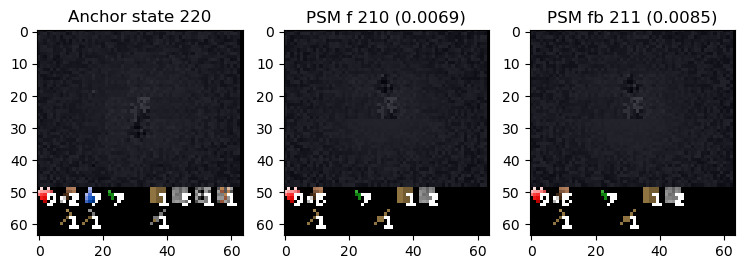

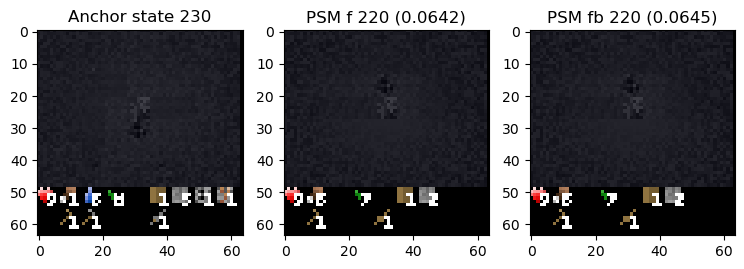

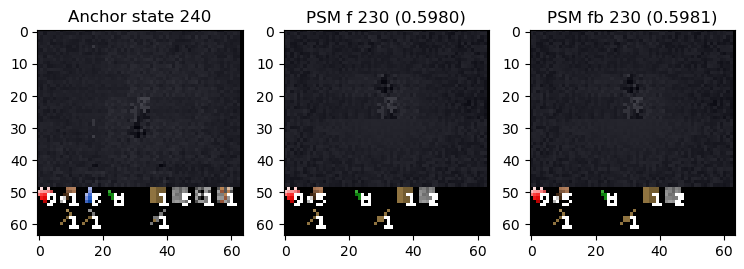

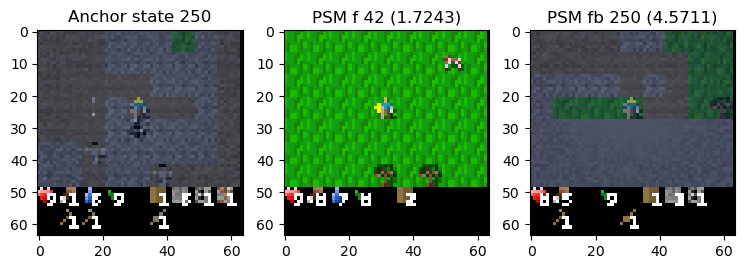

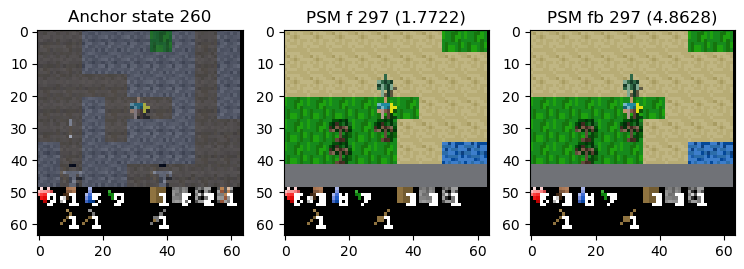

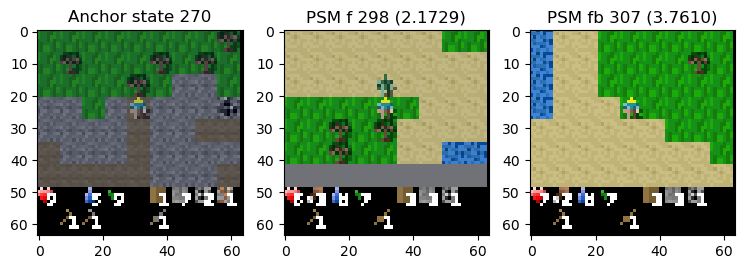

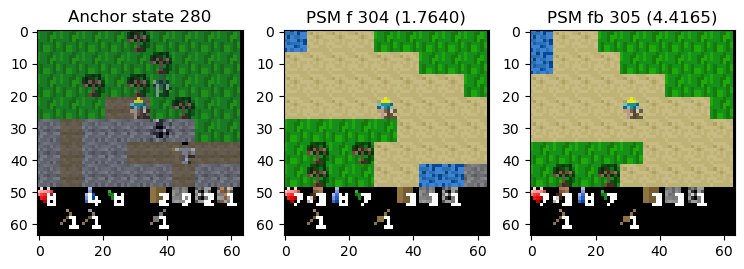

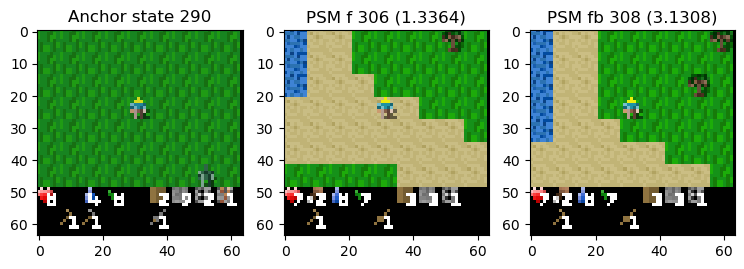

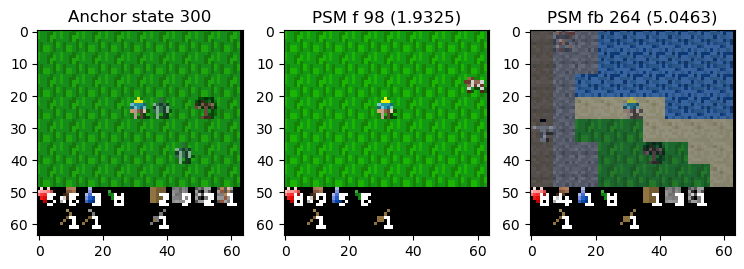

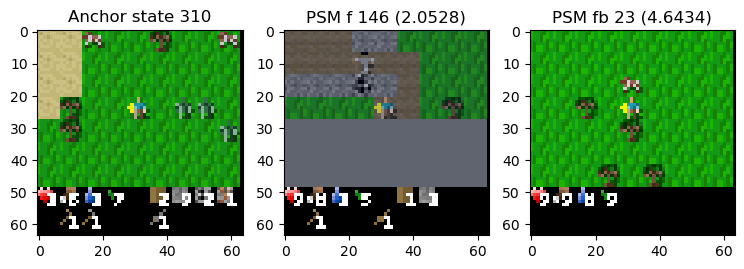

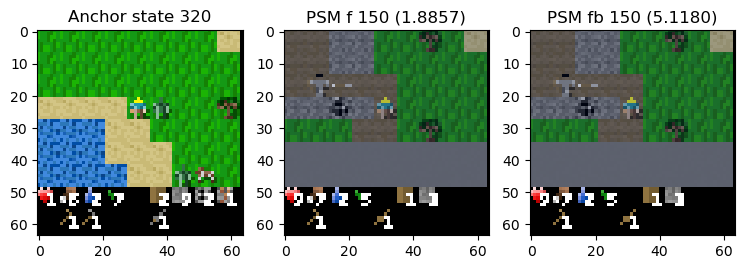

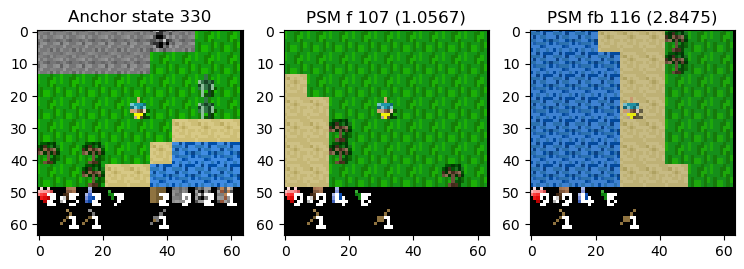

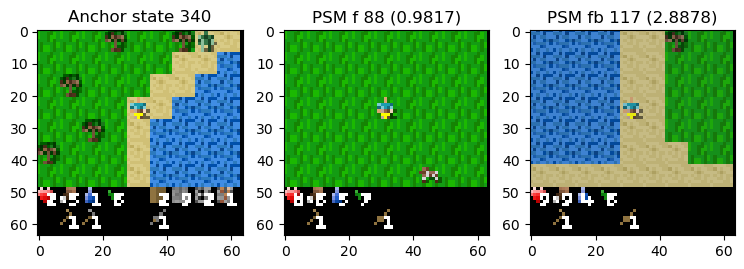

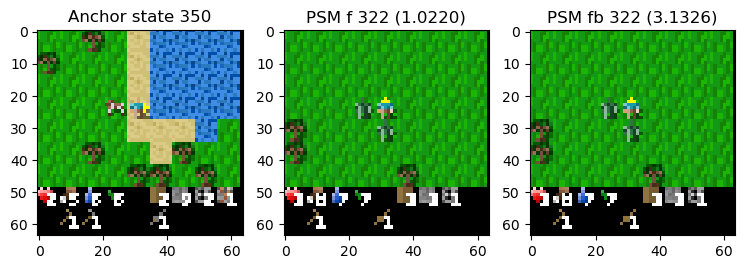

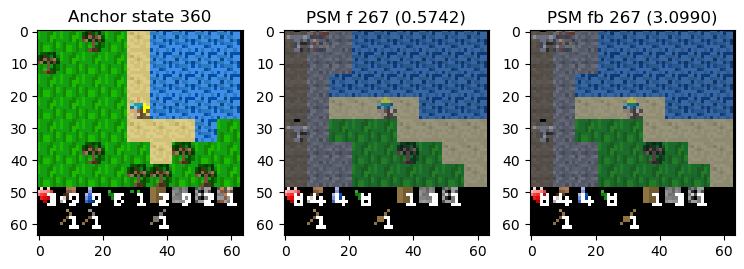

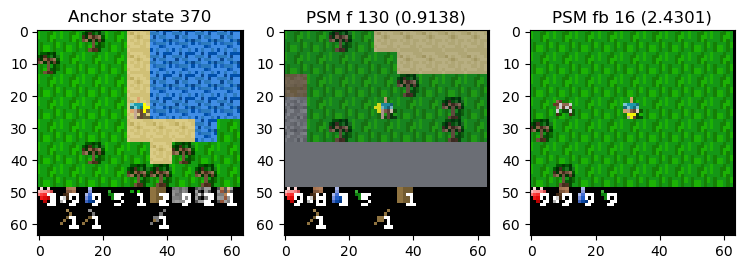

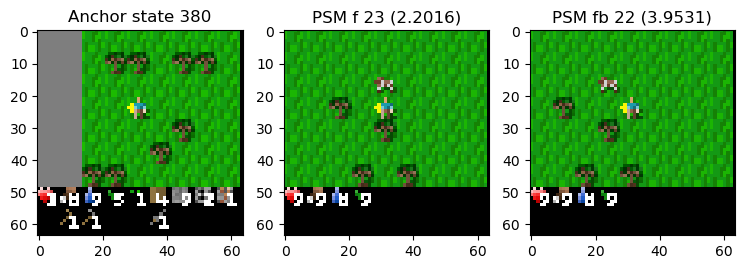

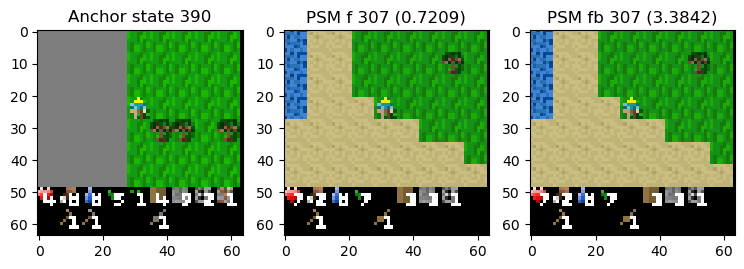

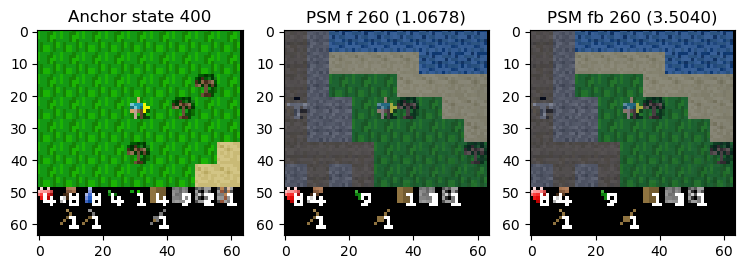

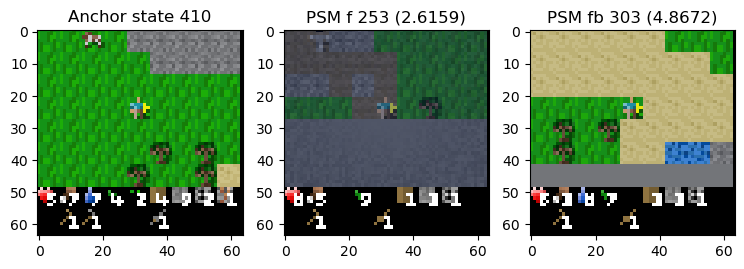

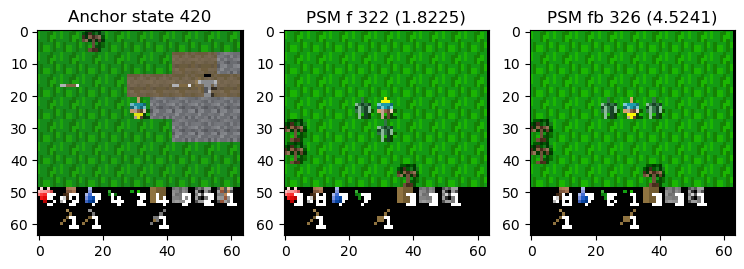

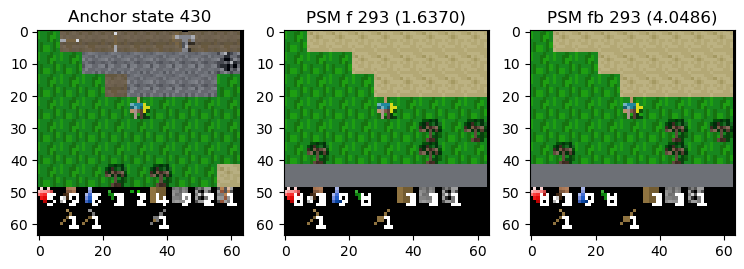

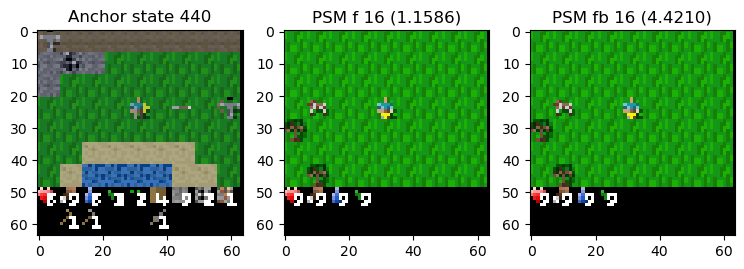

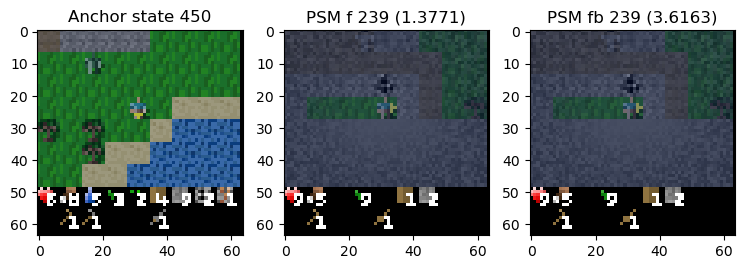

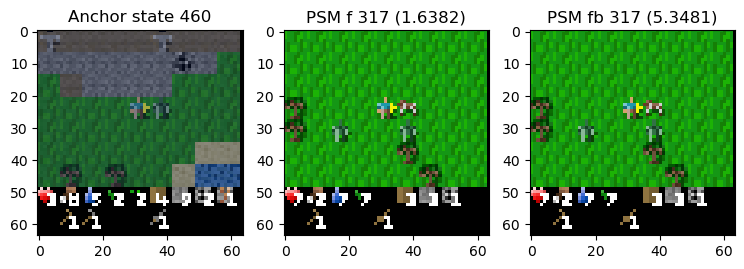

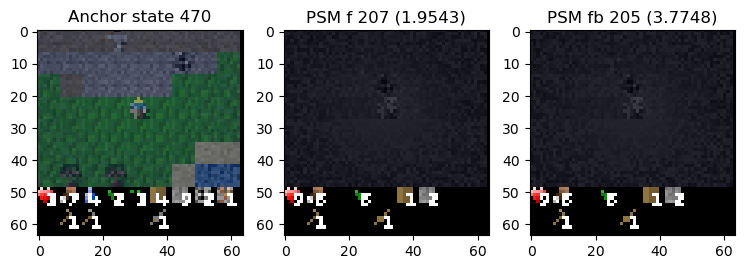

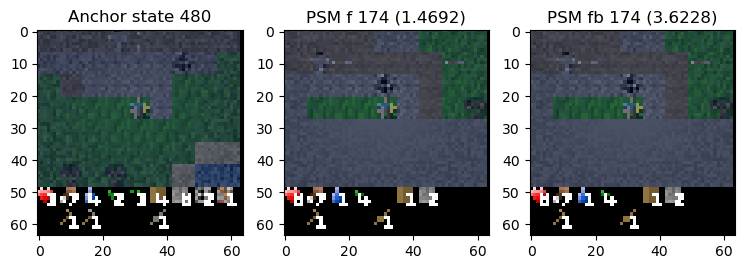

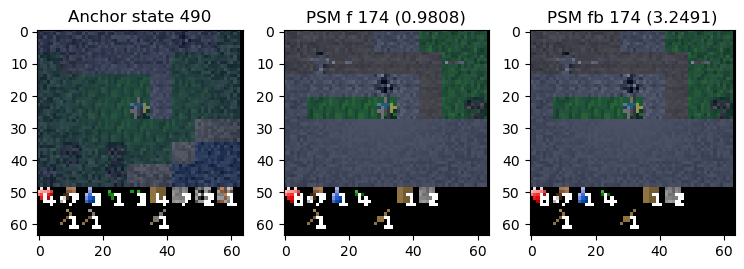

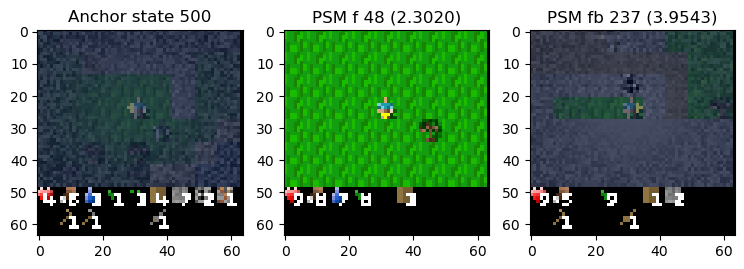

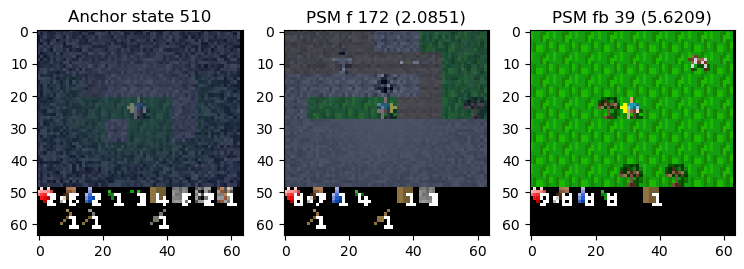

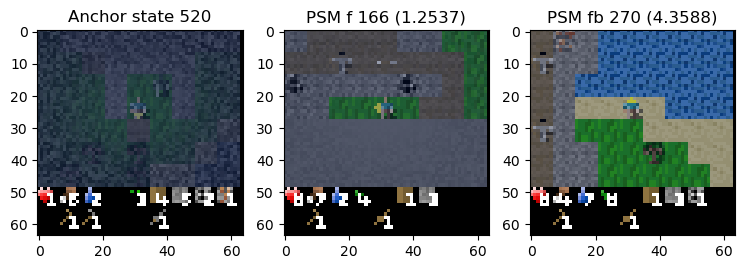

In [64]:
#psm_forward = psm.psm_default(actions_x, actions_y, gamma=0.90)
#psm_fb = psm.psm_fb(actions_x, actions_y, gamma=0.90)

psm_forward_fast = psm.psm_f_fast(actions_x, actions_y, gamma=0.8)
psm_fb_fast = psm.psm_fb_fast(actions_x, actions_y, gamma=0.8)

#assert np.allclose(psm_forward, psm_forward_fast) , "Different psm values for fast and slow version!"
#assert np.allclose(psm_fb, psm_fb_fast) , "Different psm values for fast and slow version!"

beta = 0.01
# psm_forward = np.exp(-psm_forward_fast / beta)
# psm_fb = np.exp(-psm_fb_fast / beta)

for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_forward_fast[:, compare_idx])
    idx_fb = np.argmin(psm_fb_fast[:,compare_idx])

    if compare_idx % 10 == 0:
        compare_imgs(
            np.moveaxis(states_y[compare_idx].numpy(), 0, -1), 
            np.moveaxis(states_x[idx_forward].numpy(), 0, -1), 
            np.moveaxis(states_x[idx_fb].numpy(), 0, -1), 
            f"Anchor state {compare_idx}",
            f"PSM f {idx_forward} ({psm_forward_fast[idx_forward][compare_idx]:.4f})",
            f"PSM fb {idx_fb} ({psm_fb_fast[idx_fb][compare_idx]:.4f})")


In [65]:
actions_x[150:160]

tensor([3, 3, 1, 1, 1, 5, 5, 1, 2, 2])

PSM F: mean: 0.06898203492164612 var: 0.012299858033657074
PSM FB: mean: 0.009396305307745934 var: 0.0013294111704453826


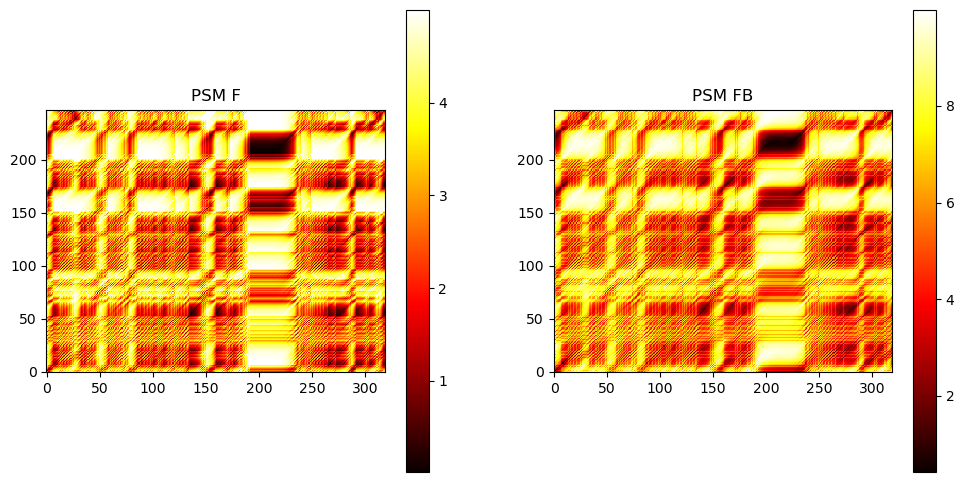

In [69]:
# states_x, actions_x = buffer.sample_trajectory()
# states_y, actions_y = buffer.sample_trajectory()
actions_x = simplify_actions(actions_x)
actions_y = simplify_actions(actions_y)
psm_f = psm.psm_f_fast(actions_x, actions_y, gamma=.8)
psm_fb = psm.psm_fb_fast(actions_x, actions_y, gamma=.8)
#print(actions_x)
# calculate measure

beta = .9
psm_f_measure = torch.exp(-psm_f/beta)
psm_fb_measure = torch.exp(-psm_fb/beta)

print(f"PSM F: mean: {psm_f_measure.mean()} var: {psm_f_measure.var()}")
print(f"PSM FB: mean: {psm_fb_measure.mean()} var: {psm_fb_measure.var()}")


fig = plt.figure(figsize=(12,6))
plot1 = fig.add_subplot(1, 2, 1)
im = plot1.imshow(psm_f.T, origin='lower', cmap='hot', interpolation='nearest')
plot1.set_title("PSM F")
fig.colorbar(im, ax=plot1)


plot2 = fig.add_subplot(1, 2, 2)
plot2.set_title("PSM FB")
im = plot2.imshow(psm_fb.T, origin='lower', cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=plot2)
plt.show()

In [70]:
print(actions_x.max())

tensor(7, dtype=torch.int32)
